In [1]:
#Created by: Kanthimathi Sankar
#Date: June 12 2017
#Purpose: Connect to PI Server and extract data from the PI Server. Write the values in the CSV file.

#Import all the neccesary libraries. If the libraries are not in the python version ,download the libraris
#eg - win32.com client -- > Goto CMD and type --> pip install win32com.client OR download from webhttps://sourceforge.net/projects/pywin32/

#Example : PiServerConnect('01-01-2005 ','12-31-2005','1d')


def PiServerConnect(starttime,endtime,timeinterval):
    
    
    import time
    from datetime import datetime, timedelta
    from win32com.client import Dispatch
    import numpy as np
    import csv
    import os
    import pandas as pd
    import datetime as dt




    #Connect to the PI Server
    tdMax = timedelta(minutes=15)
    pisdk = Dispatch('PISDK.PISDK')
    myServer = pisdk.Servers('Server Name')
    #con =Dispatch('PISDKDlg.Connections')

    #Define the start time and end to for retriving the data
    #con.Login(myServer,'','',1,0)
    piTimeStart = Dispatch('PITimeServer.PITimeFormat')
    piTimeEnd = Dispatch('PITimeServer.PITimeFormat')
    #piTimeStart.InputString = '01-01-2010 00:00:00'
    #piTimeEnd.InputString = '12-31-2010 23:59:59'
    piTimeStart = starttime
    piTimeEnd = endtime


    t0 = datetime.now()

    #Define the tag for UV254 
    sampleAsynchStatus = Dispatch('PISDKCommon.PIAsynchStatus')
    samplePointUV254 = myServer.PIPoints['UV254:COS']
    sampleValuesUV254 = samplePointUV254.Data.Summaries2(piTimeStart,piTimeEnd,timeinterval,5,0,sampleAsynchStatus)


    #Define the tag for Conductivity 
    sampleAsynchStatus = Dispatch('PISDKCommon.PIAsynchStatus')
    samplePointCond = myServer.PIPoints['CONDUCTIVITY:COS_INTAKE']
    sampleValuesCond = samplePointCond.Data.Summaries2(piTimeStart,piTimeEnd,'1d',5,0,sampleAsynchStatus)


    #Define the tag for Flow
    sampleAsynchStatus = Dispatch('PISDKCommon.PIAsynchStatus')
    samplePointFlow = myServer.PIPoints['FLOW:OAK_6710']
    sampleValuesFlow = samplePointFlow.Data.Summaries2(piTimeStart,piTimeEnd,'1d',5,0,sampleAsynchStatus)

    #Define the tag for Temp
    sampleAsynchStatus = Dispatch('PISDKCommon.PIAsynchStatus')
    samplePointTemp = myServer.PIPoints['TEMP:COS_INTAKE_AIT_3302']
    sampleValuesTemp = samplePointTemp.Data.Summaries2(piTimeStart,piTimeEnd,'1d',5,0,sampleAsynchStatus)
   
    #While checks for any exceptions by setting the limit. 
    while True:
        try:
            valsumUV254 = sampleValuesUV254("Average").Value # retrieve the value
            valsumCond = sampleValuesCond("Average").Value # retrieve the value
            valsumFlow = sampleValuesFlow("Average").Value # retrieve the value
            valsumTemp = sampleValuesTemp("Average").Value # retrieve the value
            

            break  # it will get out of infinite loop when there is no error
        except:  # it failed because server needs more time
            td = datetime.now() - t0
            if td > tdMax:
                print( "It is taking so long to get PI data ! Exiting now ....")
                exit(1)
            time.sleep(3)

    #While loop to iterate through all the data in the PI server and storing in a array variable.
    #Create an array for each and append the values in the array variable
    
    i = 1
    UV254 = []
    Cond = []
    Flow = []
    Temp = []
    dtime = []

    while i < valsumCond.Count+1:
        UV254 = np.append( UV254,valsumUV254(i).Value)
        Cond = np.append(Cond,valsumCond(i).Value)
        Flow = np.append(Flow,valsumFlow(i).Value)
        Temp = np.append(Temp,valsumTemp(i).Value)
        
        #Get the time stamp for the tag value
        
        dt = datetime.utcfromtimestamp(int(valsumCond(i).TimeStamp))
        #Seperate the year, month and day . 
        year = dt.year
        month = dt.month
        day = dt.day
        
        #Join the year, month, day and store in dt. This is done to change the datetime format to real number to write in CSV file.
        
        dt =int (''.join(str(x) for x in (year,month,day)))
        
        #append all the dates in dtimeas an list
        dtime =  np.append(dtime,dt)
        i += 1
   
    #If the values are not a good value for calculation replace them by 0
    UV254[UV254 == -2147219947 ] = 0
    Cond[Cond == -2147219947 ] = 0
    Flow[Flow == -2147219947 ] = 0
    Temp[Temp == -2147219947 ] = 0
    
    #print (chr(93))
    #Write the column values in the CSV file and save in the local server

    #time1 = datetime.strptime('01-01-2010 ','%m-%d-%Y')
    
    #zip the list helps to display in columns instead of row
    l = zip(dtime,UV254, Cond, Flow, Temp)

    #set the working directory
    os.chdir("C:\\Users\\sankar_k\\Documents\\Plots")
    #create the CSV file and write the values in the file and save it in the local dir
    csvfilename = 'rawWaterPlots.csv'
    out = open(csvfilename, 'w')
    #Assign the Column header in CSV file.
    out.write('Date,' 'UV254,' 'Conductivity,' 'Flow,' 'Temp,')
    out.write('\n')
    

    #seconds = (row[0] - 25569) * 86400.0
    for row in l:
        for column in row:
            #print(row[0])
            
            #print (datetime.fromtimestamp (row[0]))
            #print (datetime.utcfromtimestamp(float(row[0]),UTC()))
           
            #row[] = datetime(year=2011, month=1, day=15)
            out.write( '%f,' %column)
            
        out.write('\n')
       
    #close the CSV file
    out.close()
    
    

    return;




In [2]:


PiServerConnect('01-01-2005 ','12-31-2005','1d')


In [6]:
#Created by : Kanthimathi Sankar
#Created on: June 6 , 2017
#Purpose:This function reads the csv file and fetch the column values(Conductivity, UV254, Flow, Temp)
#Example: ConductivityTemperature(2010)


def ConductivityTemperatureFlowUV254(year):
    #Import all the libraries needed for the program. Use pip install in command prompt to install if already not present in Python.
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    import datetime
    import matplotlib.dates as mdates
    import os
    
     #set the working directory
    os.chdir("C:\\Users\\sankar_k\\Documents\\Plots")
    
    #Read the CSV file
    waterdata = pd.read_csv('rawWaterPlots.csv',index_col=0)
    
    
    #if condition to check if there are any non numeric values in the cloumn UV254
    #bifc checks if boolean, int, float, complex datatypes
    if not waterdata['UV254'].dtype.kind in 'bifc':
        
        #Check if the UV254 and Conductivity have non numeric data, and replace it with 0. 
        waterdata['UV254'] = np.where(waterdata['UV254']== '[-11059] No Good Data For Calculation',0 , waterdata['UV254'])
        #Convert any non numeric data to float
        waterdata['UV254'] = waterdata['UV254'].astype(float)
   
    #if condition to check if there are any non numeric values in the cloumn Conductivity
    if not waterdata['Conductivity'].dtype.kind in 'bifc':
        
        waterdata['Conductivity'] = np.where(waterdata['Conductivity']== '[-11059] No Good Data For Calculation',0 , waterdata['Conductivity'])
        waterdata['Conductivity'] = waterdata['Conductivity'].astype(float)
     

    #get the UV254 greater than 0.02 and assign None if it is less than 0.02
    waterdata['UV254'] = np.where(waterdata['UV254' ]< 0.02 , None ,waterdata['UV254'] )
    
    #assign NAN for values greater than 0.1, it will not plot plot if its NAN
    waterdata['UV254'] = np.where(waterdata['UV254' ]> 0.1 , np.nan ,waterdata['UV254'] )
   
    
    #Fetch the data  if conductivity is between 40 and 200
    waterdata = waterdata[(waterdata.Conductivity > 40) & (waterdata.Conductivity<=200) ]
    
    
    #Plot the figure
    fig = plt.figure(figsize=(20,13))
    #Create the subplot and the dual y axis
    ax = fig.add_subplot(211) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    #Plot UV254 and Conductivity from the excel sheet and set the color, linstyle ,linewidth
    waterdata.UV254.plot(ax=ax,color='blue',linewidth=2,subplots=True)
    waterdata.Conductivity.plot(ax=ax2,color='#104E8B',linestyle=':',linewidth=2,subplots=True)
    
    #set the y axis limits , i.e for UV254 and Conductivity
    ax.set_ylim(ymin=0.02,ymax=0.10)
    ax2.set_ylim(ymin=40,ymax=180)

    #Set the legend layout outside the chart.
    leg = ax.legend(['UV254'],loc = 'best',  bbox_to_anchor = (0.4, 1.2), fontsize=15)
    leg.draw_frame(False)
    leg = ax2.legend(['Conductivity'], loc = 'best', bbox_to_anchor = (0.6, 1.2), fontsize=15)
    leg.draw_frame(False)

    #Set the x axis ticks, slightly tilted at the angle of 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=25, horizontalalignment='right')

    #Set the title and reposition its location.
    #plt.title(str(year))
    title = ax.set_title(str(year), fontsize=20)
    title.set_x(0.45)
    title.set_y(1.18)

    #Mark the y axis labels.
    ax.set_ylabel('UV254')  
    ax2.set_ylabel('Conductivity')
    fig.tight_layout()
    
    #Check for non numeric data in the Flow column values
 
    if not waterdata['Temp'].dtype.kind in 'bifc':
        waterdata['Temp'] = np.where(waterdata['Temp']== '[-11059] No Good Data For Calculation',0 , waterdata['Temp'])
        #Convert any non numeric data to float
        waterdata['Temp'] = waterdata['Temp'].astype(float)
    if not waterdata['Flow'].dtype.kind in 'bifc':   
        waterdata['Flow'] = np.where(waterdata['Flow']== '[-11059] No Good Data For Calculation',0 , waterdata['Flow'])
        waterdata['Flow'] = waterdata['Flow'].astype(float)
        
    waterdata['Flow'] = np.where(waterdata['Flow'].astype(float)<0,0,waterdata['Flow'])
    
    #Fetch the data from the CSV file if flow is between 0-500 and Temp is between 0-30
    data = waterdata[(waterdata.Temp > 0) & (waterdata.Temp <=30)  & (waterdata.Flow < 500)]
   
    #Create the subplot
    ax = fig.add_subplot(212) # Create matplotlib axes
    #Create the dual Axis
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    #Fill the flow area as grey and plot the flow values from the CSV file.
    #Plot the Temp values in red
    data.Flow.plot(ax=ax,kind = 'area', color='#CCCCCC')
    data.Temp.plot(ax=ax2,color='red',linewidth=2 )

    #Set the y limits 
    ax.set_ylim(ymin=0,ymax=350)
    ax2.set_ylim(ymin=0,ymax=25)

    #Set the legend layout outside the chart.
    leg1 = ax.legend(['Flow'],loc = 'best',  bbox_to_anchor = (0.4, 1.2), fontsize=15)
    leg1.draw_frame(False)
    leg2 = ax2.legend(['Temp'], loc = 'best', bbox_to_anchor = (0.6, 1.2), fontsize=15)
    leg2.draw_frame(False)
    #plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

    plt.xticks( (25,45,75,100,130,170,190,220,250,290,310,330), ('Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec') )

    fig.autofmt_xdate()
    #plt.title("Flow-Temperature-" + str(year))
    #Mark the y axis labels
    ax.set_ylabel('Flow')
    ax2.set_ylabel('Temp')
    fig.tight_layout()
    #Adjust the horizontal space between the subplots
    plt.subplots_adjust(  hspace=0.3)
    
    #Save the figures as PDF file in the local machine
    plt.savefig('Conductivity-UV254-Flow-Temperature'+ str(year)+ '.pdf')
    #Show the plot while compiling the program.
    plt.show()


    return;


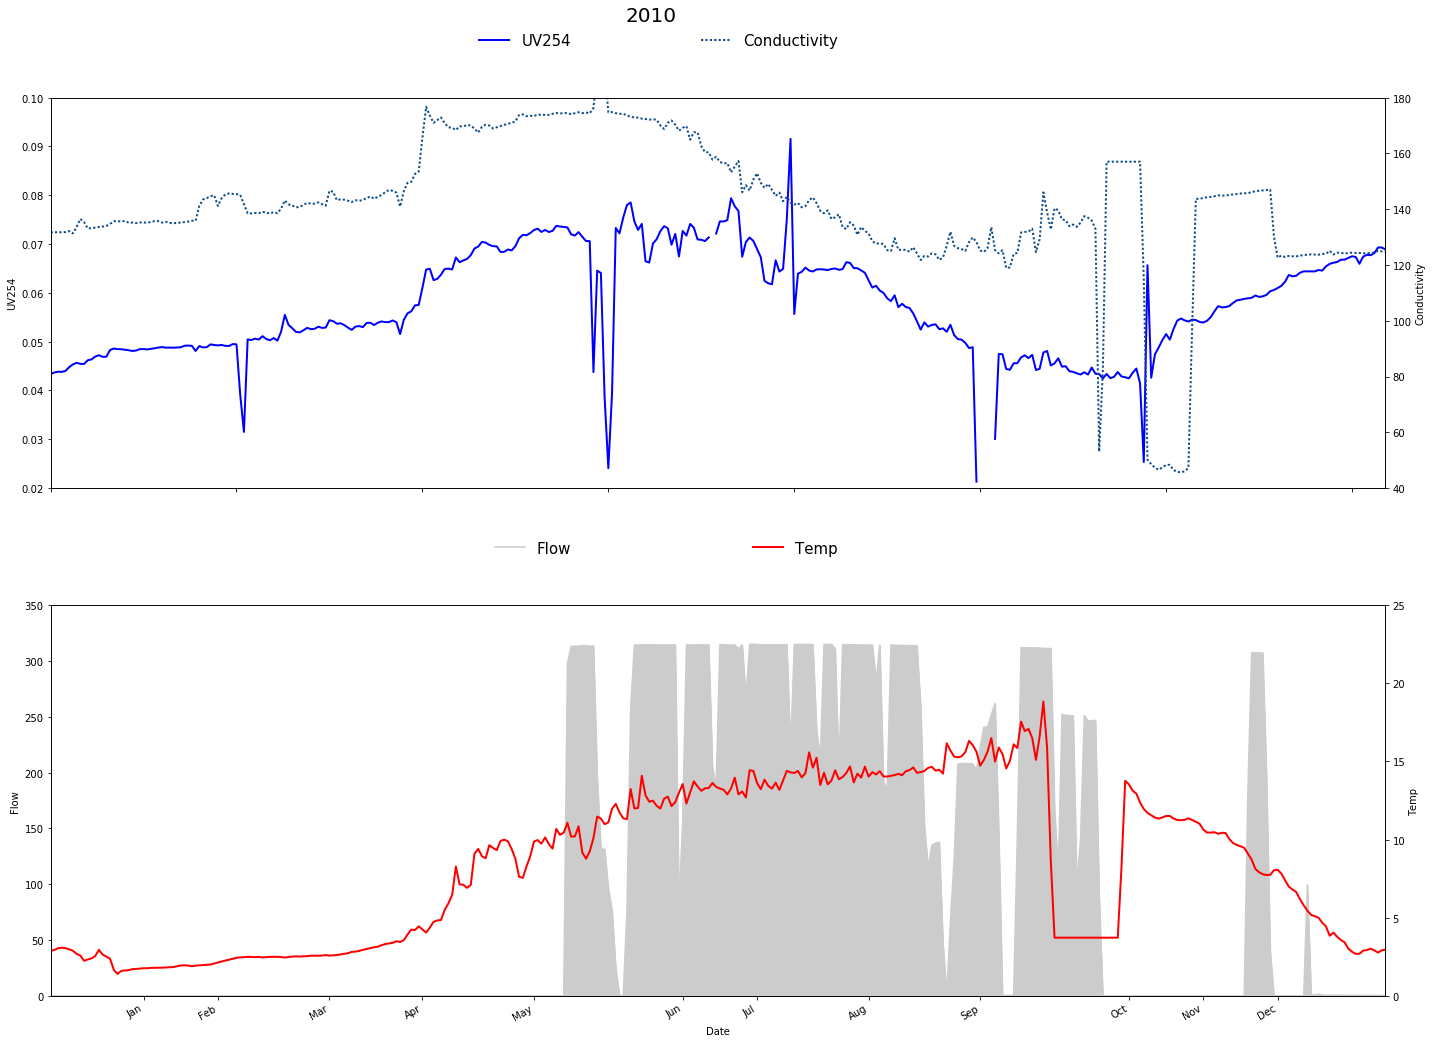

In [7]:
ConductivityTemperatureFlowUV254(2010)